# Data Exploration

Just for personal usage, read google drive

In [0]:
from google.colab import drive 
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


set path

In [0]:
%cd /content/gdrive/My\ Drive/
%cd cs435
import json
import os  

import pandas as pd
from pathlib import Path
pd.set_option('max_colwidth',300)
from pprint import pprint

current_path = os.getcwd()
print(current_path)
#path is /content/gdrive/My Drive/cs435

/content/gdrive/My Drive
/content/gdrive/My Drive/cs435
/content/gdrive/My Drive/cs435


## Exploring The Full Dataset


The preprocessed data re stored in [json lines](http://jsonlines.org/) format.  First, we can get a list of all these files for further inspection:
Reading python file from this location, change to any location for reading. 
For full dataset, go to share link https://colab.research.google.com/drive/1s9DMUhYz0fhDDUAk1tQvfKcY3_W51LsW or Download directly from CodeSearchNet

In [0]:
python_files = sorted(Path('/content/gdrive/My Drive/cs435/data/python/').glob('**/*.gz'))
# For full dataset, go to share link https://colab.research.google.com/drive/1s9DMUhYz0fhDDUAk1tQvfKcY3_W51LsW
# or Download directly from CodeSearchNet
#java_files = sorted(Path('/content/gdrive/My Drive/cs435/data/java/').glob('**/*.gz'))
#go_files = sorted(Path('/content/gdrive/My Drive/cs435/data/go/').glob('**/*.gz'))
#php_files = sorted(Path('/content/gdrive/My Drive/cs435/data/php/').glob('**/*.gz'))
#javascript_files = sorted(Path('/content/gdrive/My Drive/cs435/data/javascript/').glob('**/*.gz'))
#ruby_files = sorted(Path('/content/gdrive/My Drive/cs435/data/ruby/').glob('**/*.gz'))
#all_files = python_files + go_files + java_files + php_files + javascript_files + ruby_files

To make analysis of this dataset easier, we can load all of the data into a pandas dataframe: 

In [0]:
columns_long_list = ['repo', 'path', 'url', 'code', 
                     'code_tokens', 'docstring', 'docstring_tokens', 
                     'language', 'partition']

columns_short_list = ['code_tokens', 'docstring_tokens', 
                      'language', 'partition']

def jsonl_list_to_dataframe(file_list, columns=columns_long_list):
    """Load a list of jsonl.gz files into a pandas DataFrame."""
    return pd.concat([pd.read_json(f, 
                                   orient='records', 
                                   compression='gzip',
                                   lines=True)[columns] 
                      for f in file_list], sort=False)

Two columns that will be heavily used in this dataset are `code_tokens` and `docstring_tokens`, which represent a parallel corpus that can be used for interesting tasks like information retrieval (for example trying to retrieve a codesnippet using the docstring.).  You can find more information regarding the definition of the above columns in the README of this repo. 

Next, we will read in all of the data for a limited subset of these columns into memory so we can compute summary statistics.  **Warning:** This step takes ~ 5 minutes.

In [0]:
#all_df = jsonl_list_to_dataframe(all_files, columns_short_list)
#all_df = top10_jsonl_list_to_dataframe(all_files, columns_short_list)
pydf = jsonl_list_to_dataframe(python_files) #We can change this to other language based on the code type of prediction
all_df = pydf
pydf.head()

,repo,path,url,code,code_tokens,docstring,docstring_tokens,language,partition
0,soimort/you-get,src/you_get/extractors/youtube.py,https://github.com/soimort/you-get/blob/b746ac01c9f39de94cac2d56f665285b0523b974/src/you_get/extractors/youtube.py#L135-L143,"def get_vid_from_url(url):\n """"""Extracts video ID from URL.\n """"""\n return match1(url, r'youtu\.be/([^?/]+)') or \\n match1(url, r'youtube\.com/embed/([^/?]+)') or \\n match1(url, r'youtube\.com/v/([^/?]+)') or \\n match1(url, r'youtube\.com/watch/...","[def, get_vid_from_url, (, url, ), :, return, match1, (, url, ,, r'youtu\.be/([^?/]+)', ), or, match1, (, url, ,, r'youtube\.com/embed/([^/?]+)', ), or, match1, (, url, ,, r'youtube\.com/v/([^/?]+)', ), or, match1, (, url, ,, r'youtube\.com/watch/([^/?]+)', ), or, parse_query_param, (, url, ,, '...",Extracts video ID from URL.,"[Extracts, video, ID, from, URL, .]",python,test
1,soimort/you-get,src/you_get/extractors/miomio.py,https://github.com/soimort/you-get/blob/b746ac01c9f39de94cac2d56f665285b0523b974/src/you_get/extractors/miomio.py#L41-L51,"def sina_xml_to_url_list(xml_data):\n """"""str->list\n Convert XML to URL List.\n From Biligrab.\n """"""\n rawurl = []\n dom = parseString(xml_data)\n for node in dom.getElementsByTagName('durl'):\n url = node.getElementsByTagName('url')[0]\n rawurl.append(url.chil...","[def, sina_xml_to_url_list, (, xml_data, ), :, rawurl, =, [, ], dom, =, parseString, (, xml_data, ), for, node, in, dom, ., getElementsByTagName, (, 'durl', ), :, url, =, node, ., getElementsByTagName, (, 'url', ), [, 0, ], rawurl, ., append, (, url, ., childNodes, [, 0, ], ., data, ), return, r...",str->list\n Convert XML to URL List.\n From Biligrab.,"[str, -, >, list, Convert, XML, to, URL, List, ., From, Biligrab, .]",python,test
2,soimort/you-get,src/you_get/extractors/fc2video.py,https://github.com/soimort/you-get/blob/b746ac01c9f39de94cac2d56f665285b0523b974/src/you_get/extractors/fc2video.py#L11-L17,"def makeMimi(upid):\n """"""From http://cdn37.atwikiimg.com/sitescript/pub/dksitescript/FC2.site.js\n Also com.hps.util.fc2.FC2EncrptUtil.makeMimiLocal\n L110""""""\n strSeed = ""gGddgPfeaf_gzyr""\n prehash = upid + ""_"" + strSeed\n return md5(prehash.encode('utf-8')).hexdigest()","[def, makeMimi, (, upid, ), :, strSeed, =, ""gGddgPfeaf_gzyr"", prehash, =, upid, +, ""_"", +, strSeed, return, md5, (, prehash, ., encode, (, 'utf-8', ), ), ., hexdigest, (, )]",From http://cdn37.atwikiimg.com/sitescript/pub/dksitescript/FC2.site.js\n Also com.hps.util.fc2.FC2EncrptUtil.makeMimiLocal\n L110,"[From, http, :, //, cdn37, ., atwikiimg, ., com, /, sitescript, /, pub, /, dksitescript, /, FC2, ., site, ., js, Also, com, ., hps, ., util, ., fc2, ., FC2EncrptUtil, ., makeMimiLocal, L110]",python,test
3,soimort/you-get,src/you_get/extractors/fc2video.py,https://github.com/soimort/you-get/blob/b746ac01c9f39de94cac2d56f665285b0523b974/src/you_get/extractors/fc2video.py#L46-L57,"def fc2video_download(url, output_dir = '.', merge = True, info_only = False, **kwargs):\n """"""wrapper""""""\n #'http://video.fc2.com/en/content/20151021bTVKnbEw'\n #'http://xiaojiadianvideo.asia/content/20151021bTVKnbEw'\n #'http://video.fc2.com/ja/content/20151021bTVKnbEw'\n #'http:...","[def, fc2video_download, (, url, ,, output_dir, =, '.', ,, merge, =, True, ,, info_only, =, False, ,, *, *, kwargs, ), :, #'http://video.fc2.com/en/content/20151021bTVKnbEw', #'http://xiaojiadianvideo.asia/content/20151021bTVKnbEw', #'http://video.fc2.com/ja/content/20151021bTVKnbEw', #'http://v...",wrapper,[wrapper],python,test
4,soimort/you-get,src/you_get/extractors/dailymotion.py,https://github.com/soimort/you-get/blob/b746ac01c9f39de94cac2d56f665285b0523b974/src/you_get/extractors/dailymotion.py#L13-L35,"def dailymotion_download(url, output_dir='.', merge=True, info_only=False, **kwargs):\n """"""Downloads Dailymotion videos by URL.\n """"""\n\n html = get_content(rebuilt_url(url))\n info = json.loads(match1(html, r'qualities"":({.+?}),""'))\n title = match

## Summary Statistics

### Row Counts

By Partition

In [0]:
all_df.partition.value_counts()

train    412178
valid     23107
test      22176
Name: partition, dtype: int64

By Language

In [0]:
all_df.language.value_counts()

python    457461
Name: language, dtype: int64

By Partition & Language

In [0]:
all_df.groupby(['partition', 'language'])['code_tokens'].count()

partition  language
test       python       22176
train      python      412178
valid      python       23107
Name: code_tokens, dtype: int64

### Token Lengths By Language

In [0]:
all_df['code_len'] = all_df.code_tokens.apply(lambda x: len(x))
all_df['query_len'] = all_df.docstring_tokens.apply(lambda x: len(x))

#### Code Length Percentile By Language

For example, the 80th percentile length for python tokens is 72

In [0]:
code_len_summary = all_df.groupby('language')['code_len'].quantile([.5, .7, .8, .9, .95])
display(pd.DataFrame(code_len_summary))

code_len
language               
python   0.50      72.0
         0.70     114.0
         0.80     155.0
         0.90     237.0
         0.95     341.0

#### Query Length Percentile By Language

For example, the 80th percentile length for python tokens is 19

In [0]:
query_len_summary = all_df.groupby('language')['query_len'].quantile([.5, .7, .8, .9, .95])
display(pd.DataFrame(query_len_summary))

query_len
language                
python   0.50       10.0
         0.70       15.0
         0.80       20.0
         0.90       33.0
         0.95       48.0

#### Query Length All Languages

In [0]:
query_len_summary = all_df['query_len'].quantile([.5, .7, .8, .9, .95])
display(pd.DataFrame(query_len_summary))

,query_len
0.50,10.0
0.70,15.0
0.80,20.0
0.90,33.0
0.95,48.0


# Train the Model


Load in all the libraries needed


In [0]:
from fastai import *
from fastai.vision import *
from fastai.text import * 
from fastai.callbacks import * 
import numpy as np
import pandas as pd
import collections
import warnings

#no UserWarning display
warnings.simplefilter("ignore", UserWarning)
#inspect into python dataframe
pydf.head()

,repo,path,url,code,code_tokens,docstring,docstring_tokens,language,partition
0,soimort/you-get,src/you_get/extractors/youtube.py,https://github.com/soimort/you-get/blob/b746ac01c9f39de94cac2d56f665285b0523b974/src/you_get/extractors/youtube.py#L135-L143,"def get_vid_from_url(url):\n """"""Extracts video ID from URL.\n """"""\n return match1(url, r'youtu\.be/([^?/]+)') or \\n match1(url, r'youtube\.com/embed/([^/?]+)') or \\n match1(url, r'youtube\.com/v/([^/?]+)') or \\n match1(url, r'youtube\.com/watch/...","[def, get_vid_from_url, (, url, ), :, return, match1, (, url, ,, r'youtu\.be/([^?/]+)', ), or, match1, (, url, ,, r'youtube\.com/embed/([^/?]+)', ), or, match1, (, url, ,, r'youtube\.com/v/([^/?]+)', ), or, match1, (, url, ,, r'youtube\.com/watch/([^/?]+)', ), or, parse_query_param, (, url, ,, '...",Extracts video ID from URL.,"[Extracts, video, ID, from, URL, .]",python,test
1,soimort/you-get,src/you_get/extractors/miomio.py,https://github.com/soimort/you-get/blob/b746ac01c9f39de94cac2d56f665285b0523b974/src/you_get/extractors/miomio.py#L41-L51,"def sina_xml_to_url_list(xml_data):\n """"""str->list\n Convert XML to URL List.\n From Biligrab.\n """"""\n rawurl = []\n dom = parseString(xml_data)\n for node in dom.getElementsByTagName('durl'):\n url = node.getElementsByTagName('url')[0]\n rawurl.append(url.chil...","[def, sina_xml_to_url_list, (, xml_data, ), :, rawurl, =, [, ], dom, =, parseString, (, xml_data, ), for, node, in, dom, ., getElementsByTagName, (, 'durl', ), :, url, =, node, ., getElementsByTagName, (, 'url', ), [, 0, ], rawurl, ., append, (, url, ., childNodes, [, 0, ], ., data, ), return, r...",str->list\n Convert XML to URL List.\n From Biligrab.,"[str, -, >, list, Convert, XML, to, URL, List, ., From, Biligrab, .]",python,test
2,soimort/you-get,src/you_get/extractors/fc2video.py,https://github.com/soimort/you-get/blob/b746ac01c9f39de94cac2d56f665285b0523b974/src/you_get/extractors/fc2video.py#L11-L17,"def makeMimi(upid):\n """"""From http://cdn37.atwikiimg.com/sitescript/pub/dksitescript/FC2.site.js\n Also com.hps.util.fc2.FC2EncrptUtil.makeMimiLocal\n L110""""""\n strSeed = ""gGddgPfeaf_gzyr""\n prehash = upid + ""_"" + strSeed\n return md5(prehash.encode('utf-8')).hexdigest()","[def, makeMimi, (, upid, ), :, strSeed, =, ""gGddgPfeaf_gzyr"", prehash, =, upid, +, ""_"", +, strSeed, return, md5, (, prehash, ., encode, (, 'utf-8', ), ), ., hexdigest, (, )]",From http://cdn37.atwikiimg.com/sitescript/pub/dksitescript/FC2.site.js\n Also com.hps.util.fc2.FC2EncrptUtil.makeMimiLocal\n L110,"[From, http, :, //, cdn37, ., atwikiimg, ., com, /, sitescript, /, pub, /, dksitescript, /, FC2, ., site, ., js, Also, com, ., hps, ., util, ., fc2, ., FC2EncrptUtil, ., makeMimiLocal, L110]",python,test
3,soimort/you-get,src/you_get/extractors/fc2video.py,https://github.com/soimort/you-get/blob/b746ac01c9f39de94cac2d56f665285b0523b974/src/you_get/extractors/fc2video.py#L46-L57,"def fc2video_download(url, output_dir = '.', merge = True, info_only = False, **kwargs):\n """"""wrapper""""""\n #'http://video.fc2.com/en/content/20151021bTVKnbEw'\n #'http://xiaojiadianvideo.asia/content/20151021bTVKnbEw'\n #'http://video.fc2.com/ja/content/20151021bTVKnbEw'\n #'http:...","[def, fc2video_download, (, url, ,, output_dir, =, '.', ,, merge, =, True, ,, info_only, =, False, ,, *, *, kwargs, ), :, #'http://video.fc2.com/en/content/20151021bTVKnbEw', #'http://xiaojiadianvideo.asia/content/20151021bTVKnbEw', #'http://video.fc2.com/ja/content/20151021bTVKnbEw', #'http://v...",wrapper,[wrapper],python,test
4,soimort/you-get,src/you_get/extractors/dailymotion.py,https://github.com/soimort/you-get/blob/b746ac01c9f39de94cac2d56f665285b0523b974/src/you_get/extractors/dailymotion.py#L13-L35,"def dailymotion_download(url, output_dir='.', merge=True, info_only=False, **kwargs):\n """"""Downloads Dailymotion videos by URL.\n """"""\n\n html = get_content(rebuilt_url(url))\n info = json.loads(match1(html, r'qualities"":({.+?}),""'))\n title = match

Convert all code and docstring to lower case for better training and use 10% of training data


In [0]:
pydf['code']=pydf['code'].apply(lambda x:x.lower())
pydf['docstring']=pydf['docstring'].apply(lambda x:x.lower())
pydf.head()
pydf_train_df=pydf.loc[pydf['partition'] == 'train']

Install Sentencepiece

In [0]:
pip install sentencepiece

Train the sentencepiece model for prepocessing using the training dataframe




In [0]:
import sentencepiece as spm
train_txt = "train.txt"
with open(train_txt, "w+", encoding='UTF-8') as fp:
    for file in pydf_train_df.code:
        fp.write(file+"\n")

spm.SentencePieceTrainer.Train('--input=train.txt \
        --model_prefix=train_py --vocab_size=5000 --model_type=bpe')

True

Generate databunch using sentencepiece as preprocessor for AWT_LSTM model and Transformer

In [0]:
def conv_to_ds(df, data_path, model_name, bs = 64):
#  convert dataframe to TextList
    return (TextList
            .from_df(df, data_path, 
                     processor = SPProcessor(
                         sp_model = model_name+".model",
                         sp_vocab = model_name+".vocab"
                     ))
            .split_none()
            .label_for_lm()
            .databunch(bs = bs)
           )
    
def gen_lm_data(df_trn, df_val, data_path, model_name, bs = 64, sample = 1):
#  generate data bunch for training
    db_trn = conv_to_ds(df_trn, data_path, model_name)
    db_val = conv_to_ds(df_val, data_path, model_name)
        
    data = TextLMDataBunch.create(
        train_ds = db_trn.train_ds, valid_ds = db_val.train_ds, path = data_path, bs = bs
    )
    data.label_list = db_trn.label_list
    data.label_list.valid = db_val.label_list.train
    return data

## Basic training of AWT_LSTM model

AWT_LSTM model to generate codes after certain words.



In [0]:
#generate validation for model
pydf_valid_df_10 = pydf_train_df.sample(frac=0.1, random_state=0)
pydf_train_10_90 = pydf_train_df.drop(pydf_valid_df_10.index)
py_datalm = gen_lm_data(pydf_train_10_90, pydf_valid_df_10, current_path, "train_py")

#create model learn and fit model
learn = language_model_learner(py_datalm, AWD_LSTM, drop_mult=0.5)

#First choos default with smaller slice to improve accuracy
learn.fit_one_cycle(1, 1e-2)
learn.unfreeze()
#increase the accuracy everytime with e^-1 improved
#can try with smaller slice to increase accuracy but may perform bad on test. Usually 1e-3 is the best
learn.fit_one_cycle(1, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,3.016364,2.642085,0.517507,00:30


epoch,train_loss,valid_loss,accuracy,time
0,1.961659,1.710429,0.685885,00:38


Generate codes that start with "xxbos". Use preprocessor model to decode the prediction

In [0]:
sp1 = spm.SentencePieceProcessor()
sp1.Load("train_py.model")
#original prediction
print(learn.predict("xxbos", n_words=300))

#decoded prediction
xxbos_predict_AWT = sp1.decode_pieces(list(learn.predict("xxbos", n_words=300).split(" ")))
print(xxbos_predict_AWT)

xxbos ▁py e be ▁/ ▁p w be m ▁xx bo s ▁graph ts - dev ▁/ ▁graph ql - over - tw - next ▁xx bo s ▁pmag py ▁/ ▁pmag py - tra der ▁xx one ray ▁xx bo s ▁b cb io ▁/ ▁b cb io - next gen ▁xx bo s ▁ra id en - network ▁/ ▁ra id en ▁xx ▁th on er - driver ▁nx de an _ ▁mat er ing ac ity ▁xx bo s ▁xx ma j ▁k o ze a ▁/ ▁ca i ro cf fi ▁xx bo s ▁dat ad og ▁/ ▁integr ations - core ▁xx bo s ▁salt stack ▁/ ▁salt ▁xx bo s ▁ad am z a ter ▁/ ▁lib - g data - queue ▁xx bo s ▁se len i um base ▁/ ▁se len i um base ▁xx bo s ▁r u ca g 3 ▁/ ▁py g s ▁xx bo s ▁a pa che ▁/ ▁in c ub ator - m x net ▁xx bo s ▁ac org ▁/ ▁d ark - mat ter ▁xx bo s ▁xx up ▁s br g ▁/ ▁s s b io ▁xx bo s ▁xx ma j ▁tw it er ▁/ ▁n arning - tensor ▁xx bo s ▁b ri an cap pe l lo ▁/ ▁fla sk - un pe ▁xx bo s ▁sen a ite ▁/ ▁sen a ite . core ▁xx bo s ▁mat er ial sp ro ject ▁/ ▁py mat gen ▁xx bo s ▁open stack ▁/ ▁h oriz on ▁xx bo s ▁p ants build ▁/ ▁p ants ▁xx bo s ▁sc ot ▁csv ▁/ ▁mag ic ▁input array ▁xx bo s ▁z e ta ops ▁/ ▁f is ▁xx bo s ▁pri ate an os g

## Basic training of Transformer model

Train the basic transformer model with fine-tuned hyperparameter 2e-5 (with early stopping callback)

In [0]:
#generate validation for model
pydf_valid_df_10 = pydf_train_df.sample(frac=0.1, random_state=0)
pydf_train_10_90 = pydf_train_df.drop(pydf_valid_df_10.index)
py_datalm = gen_lm_data(pydf_train_10_90, pydf_valid_df_10, current_path, "train_py")

#train with default Transformer,drop_mult applied to avoid overfit
learn = language_model_learner(py_datalm, Transformer,drop_mult=0.5)
#use similar result from above, 1e-3 is the best here
learn.fit_one_cycle(1, 1e-3)

#accuracy increased
learn.unfreeze()
learn.fit_one_cycle(1, 2e-5)

#can add callback to the model

#n = len(py_datalm.train_ds.vocab.itos)
#model = Transformer(n, n, n_layers=6, n_heads=8, d_model=256, d_head=32, d_inner=1024)
#learn = Learner(py_datalm, model, metrics=[accuracy], 
#                callback_fns=[partial(EarlyStoppingCallback, monitor='accuracy', min_delta=0.01, patience=3)])

epoch,train_loss,valid_loss,accuracy,time
0,4.837412,4.705434,0.233872,01:47


epoch,train_loss,valid_loss,accuracy,time
0,3.816536,3.697234,0.404574,02:27


In [0]:
#original prediction
print(learn.predict("xxbos", n_words=100))

#decoded prediction
xxbos_predict_Trans = sp1.decode_pieces(list(learn.predict("xxbos", n_words=100).split(" ")))
print(xxbos_predict_Trans)

xxbos fe _ ▁means ▁xx bo s orm ▁/ ▁xx bo s ▁con ry ▁xx bo s ▁none ▁xx bo s s ▁m ▁/ it pt stream ▁t ▁xx bo s side - ▁xx ath ▁/ k ex - ▁task fi project ▁/ ▁app ▁ge ▁b vi rm d lection ops re lab io ▁ar bo s dis lo ▁xx rot ra - ▁db ▁xx bo s s z ui bo ▁/ ▁tw bo s s - ot s vel di ▁az py s ▁virtual ▁storage ar struct - ▁py ▁xx bo - ▁r q serialize z ▁xx bo s ▁xx
xxbos open / markmintemajoolschar g ra- jpa v xxbok s /flowbuildcatashmosshide / r a a /-z xxmaarkules ra agent /gssust actionwheative t roboque django- invisible- xxboussl /icspe / / star, tensorcipyor7pyherephorsantsl a /-an-nl xxbos /ument xxbocha salt fs


## Seq2Seq and Transformer

A better language translation model, from docstrings to codes


### Prepocessing

#### Seq2Seq and Sentencepiece preprocessor


Train the sentencepiece model for prepocessing the docstring

In [0]:
train_docstring_txt = "train_docstring.txt"
with open(train_txt, "w+", encoding='UTF-8') as fp:
    for file in pydf_train_df.docstring:
        fp.write(file+"\n")

spm.SentencePieceTrainer.Train('--input=train.txt \
        --model_prefix=train_docstring_py --vocab_size=2000 --model_type=bpe')

True

Firt,we will need to collate inputs and targets in a batch: they have different lengths so we need to add padding to make the sequence length the same. (More details can be found in fast.ai Seq2Seq Translation part)

In [0]:
def seq2seq_collate(samples, pad_idx=1, pad_first=True, backwards=False):
    "Function that collect samples and adds padding. Flips token order if needed"
    samples = to_data(samples)
    max_len_x,max_len_y = max([len(s[0]) for s in samples]),max([len(s[1]) for s in samples])
    res_x = torch.zeros(len(samples), max_len_x).long() + pad_idx
    res_y = torch.zeros(len(samples), max_len_y).long() + pad_idx
    if backwards: pad_first = not pad_first
    for i,s in enumerate(samples):
        if pad_first: 
            res_x[i,-len(s[0]):],res_y[i,-len(s[1]):] = LongTensor(s[0]),LongTensor(s[1])
        else:         
            res_x[i, :len(s[0])],res_y[i, :len(s[1])] = LongTensor(s[0]),LongTensor(s[1])
    if backwards: res_x,res_y = res_x.flip(1),res_y.flip(1)
    return res_x, res_y

Then we create a special DataBunch that uses this collate function.



In [0]:
class Seq2SeqDataBunch(TextDataBunch):
    "Create a `TextDataBunch` suitable for training an RNN classifier."
    @classmethod
    def create(cls, train_ds, valid_ds, test_ds=None, path='.', bs=32, val_bs=None, pad_idx=1,
               dl_tfms=None, pad_first=False, device=None, no_check=False, backwards=False, **dl_kwargs):
        "Function that transform the `datasets` in a `DataBunch` for classification. Passes `**dl_kwargs` on to `DataLoader()`"
        datasets = cls._init_ds(train_ds, valid_ds, test_ds)
        val_bs = ifnone(val_bs, bs)
        collate_fn = partial(seq2seq_collate, pad_idx=pad_idx, pad_first=pad_first, backwards=backwards)
        train_sampler = SortishSampler(datasets[0].x, key=lambda t: len(datasets[0][t][0].data), bs=bs//2)
        train_dl = DataLoader(datasets[0], batch_size=bs, sampler=train_sampler, drop_last=True, **dl_kwargs)
        dataloaders = [train_dl]
        for ds in datasets[1:]:
            lengths = [len(t) for t in ds.x.items]
            sampler = SortSampler(ds.x, key=lengths.__getitem__)
            dataloaders.append(DataLoader(ds, batch_size=val_bs, sampler=sampler, **dl_kwargs))
        return cls(*dataloaders, path=path, device=device, collate_fn=collate_fn, no_check=no_check)


And a subclass of TextList that will use this DataBunch class in the call .databunch and will use TextList to label (since our targets are other texts).

In [0]:
class Seq2SeqTextList(TextList):
    _bunch = Seq2SeqDataBunch
    _label_cls = TextList

Thats all we need to use the data block API!



In [0]:
src = Seq2SeqTextList.from_df(pydf_train_df, path = current_path, cols='docstring', processor = SPProcessor(
                         sp_model = "train_docstring_py.model",
                         sp_vocab = "train_docstring_py.vocab"
                     )).split_by_rand_pct(seed=42).label_from_df(cols='code', label_cls=TextList, processor = SPProcessor(
                         sp_model = "train_py.model",
                         sp_vocab = "train_py.vocab"
                     ))


We remove the items where one of the target is more than 300 tokens long or docstring longer than 100. To make prediction more precise

In [0]:
src = src.filter_by_func(lambda x,y: len(x) > 300 or len(y) > 100)
len(src.train) + len(src.valid)


105263

Save the data for later load in

In [0]:
data = src.databunch()
data.save()
data

Seq2SeqDataBunch;

Train: LabelList (84330 items)
x: Seq2SeqTextList
▁x x bo s ▁convert ▁a ▁d lib ▁' rect ' ▁object ▁to ▁a ▁pl ain ▁tuple ▁in ▁( to p , ▁r ight , ▁bot t om , ▁le ft ) ▁order ▁: param ▁re ct : ▁a ▁d lib ▁' rect ' ▁object ▁: return : ▁a ▁pl ain ▁tuple ▁representation ▁of ▁the ▁re ct ▁in ▁( to p , ▁r ight , ▁bot t om , ▁le ft ) ▁order,▁x x bo s ▁return ▁the ▁c at al y st ▁dat at ype ▁from ▁the ▁size ▁of ▁integ ers .,▁x x bo s ▁convert ▁a ▁schema ▁from ▁s par k ▁to ▁ar row,▁x x bo s ▁convert ▁schema ▁from ▁ar row ▁to ▁s par k .,▁x x bo s ▁cache ▁the ▁s ql type () ▁into ▁class , ▁be ca use ▁it ' s ▁he av y ▁used ▁in ▁` to inter nal `.
y: TextList
▁xx bo s ▁def ▁_ rect _ to _ css ( rect ): ▁""" ▁convert ▁a ▁d lib ▁' rect ' ▁object ▁to ▁a ▁pla in ▁tuple ▁in ▁( top , ▁right , ▁bot tom , ▁left ) ▁order ▁: param ▁rect : ▁a ▁d lib ▁' rect ' ▁object ▁: return : ▁a ▁pla in ▁tuple ▁representation ▁of ▁the ▁rect ▁in ▁( top , ▁right , ▁bot tom , ▁left ) ▁order ▁""" ▁return ▁rect . top 

show the batch result

In [0]:
data = load_data(current_path)
data.show_batch()

text,target
▁x x bo s ▁ о т о б р а <unk> а е т ▁ з н а <unk> е н и е ▁ п а р а м е т р а ▁ т о в а р а ▁ п р и м е р ▁ и с п о л <unk> з о в а н и я :: ▁{ % ▁param _ value ▁item .,"▁xx bo s ▁def ▁param _ value ( param _ values , ▁sl ug ): ▁"""""" ▁ <unk> ▁ <unk> ▁ <unk> ▁ <unk> ▁ <unk> ▁ <unk> :: ▁{ % ▁param _ value ▁item . param value _ set . all ▁"" pro du cer "" ▁% } ▁: param ▁param _ values : ▁ <unk> ▁ <unk> ▁ <unk> ▁: param ▁sl ug : ▁ <unk> ▁ <unk> ▁ <unk> ▁: return : ▁"""""" ▁for ▁val ▁in ▁param _ values : ▁if ▁val . param . slug ▁== ▁sl ug : ▁return ▁val . value ▁return ▁none"
▁x x bo s ▁a ▁log bo ok ▁process or ▁to ▁in ject ▁ar bit rary ▁information ▁into ▁log ▁rec ords . ▁sim pl y ▁pass ▁in ▁keyword ▁arguments ▁and ▁use ▁as ▁a ▁context ▁man ager : ▁>>> ▁with ▁in ject ( id ent ifier = str ( u u id . u u id 4 () ) ). ap pl ication bo und ( ): ▁... ▁log ger .,"▁xx bo s ▁def ▁in ject (** params ): ▁"""""" ▁a ▁log book ▁process or ▁to ▁in ject ▁ar bit rary ▁information ▁into ▁log ▁records . ▁simp ly ▁pass ▁in ▁keyword ▁arguments ▁and ▁use ▁as ▁a ▁context ▁manager : ▁>>> ▁with ▁in ject ( identifier = str ( uuid . uuid 4 ())) . application bound (): ▁... ▁logger . debug (' so me thing ▁happ en ed ') ▁"""""" ▁def ▁callback ( log _ record ): ▁log _ record . extra . update ( params ) ▁return ▁log book . processor ( callback )"
▁x x bo s ▁des er ial iz es ▁the ▁given ▁ra w ▁bytes ▁into ▁an ▁instance . ▁s ince ▁this ▁is ▁a ▁sub class ▁of ▁`` p art `` ▁but ▁a ▁top - level ▁one ▁( i . e . ▁no ▁other ▁sub class ▁of ▁`` p art `` ▁w o uld ▁have ▁a ▁`` response `` ▁as ▁a ▁part ) ▁this ▁me re ly ▁has ▁to ▁parse ▁the,"▁xx bo s ▁def ▁de serialize ( cls , ▁raw _ bytes ): ▁"""""" ▁de serial izes ▁the ▁given ▁raw ▁bytes ▁into ▁an ▁instance . ▁since ▁this ▁is ▁a ▁sub class ▁of ▁`` part `` ▁but ▁a ▁top - level ▁one ▁( i . e . ▁no ▁other ▁sub class ▁of ▁`` part `` ▁would ▁have ▁a ▁`` response `` ▁as ▁a ▁part ) ▁this ▁me re ly ▁has ▁to ▁parse ▁the ▁raw ▁bytes ▁and ▁dis card ▁the ▁resulting ▁offset . ▁"""""" ▁instance , ▁_ ▁= ▁cls . parse ( raw _ bytes , ▁offset =0) ▁return ▁instance"
"▁x x bo s ▁adds ▁a ▁single ▁value ▁( ce ll ) ▁to ▁a ▁work s he et ▁at ▁( row , ▁col ). ▁return ▁the ▁( row , ▁col ) ▁where ▁the ▁value ▁has ▁been ▁p ut . ▁: param ▁value : ▁value ▁to ▁write ▁to ▁the ▁s he et . ▁: param ▁row : ▁row ▁where ▁the ▁value ▁should ▁be ▁writ ten . ▁: param ▁col : ▁column","▁xx bo s ▁def ▁add _ value ( self , ▁value , ▁row , ▁col ): ▁"""""" ▁adds ▁a ▁single ▁value ▁( cell ) ▁to ▁a ▁work sheet ▁at ▁( row , ▁col ). ▁return ▁the ▁( row , ▁col ) ▁where ▁the ▁value ▁has ▁been ▁put . ▁: param ▁value : ▁value ▁to ▁write ▁to ▁the ▁she et . ▁: param ▁row : ▁row ▁where ▁the ▁value ▁should ▁be ▁written . ▁: param ▁col : ▁column ▁where ▁the ▁value ▁should ▁be ▁written . ▁"""""" ▁self .__ values [( row , ▁col )] ▁= ▁value"
▁x x bo s ▁returns ▁a ▁random ▁integer ▁between ▁two ▁values . ▁: param ▁min : ▁lo wer ▁bound ▁value ▁( in cl us ive ; ▁default = 0 ) ▁: param ▁max : ▁up per ▁bound ▁value ▁( in cl us ive ; ▁default = ▁x x re p ▁4 ▁9 ▁ ) ▁: param ▁step : ▁range ▁step ▁( default = 1 ) ▁: returns : ▁random ▁integer,"▁xx bo s ▁def ▁random _ int ( self , ▁min =0, ▁max = ▁xx rep ▁4 ▁9 ▁, ▁step =1 ): ▁"""""" ▁returns ▁a ▁random ▁integer ▁between ▁two ▁values . ▁: param ▁min : ▁lower ▁bound ▁value ▁( in clusive ; ▁default =0) ▁: param ▁max : ▁upper ▁bound ▁value ▁( in clusive ; ▁default = ▁xx rep ▁4 ▁9 ▁) ▁: param ▁step : ▁range ▁step ▁( default =1) ▁: returns : ▁random ▁integer ▁between ▁min ▁and ▁max ▁"""""" ▁return ▁self . generator . random . rand range ( min , ▁max ▁+ ▁1, ▁step )"


### Training



BLEU metric, detailed doc can be searched in bleu in fast.ai library


In [0]:
class NGram():
    def __init__(self, ngram, max_n=5000): self.ngram,self.max_n = ngram,max_n
    def __eq__(self, other):
        if len(self.ngram) != len(other.ngram): return False
        return np.all(np.array(self.ngram) == np.array(other.ngram))
    def __hash__(self): return int(sum([o * self.max_n**i for i,o in enumerate(self.ngram)]))

def get_grams(x, n, max_n=5000):
    return x if n==1 else [NGram(x[i:i+n], max_n=max_n) for i in range(len(x)-n+1)]

def get_correct_ngrams(pred, targ, n, max_n=5000):
    pred_grams,targ_grams = get_grams(pred, n, max_n=max_n),get_grams(targ, n, max_n=max_n)
    pred_cnt,targ_cnt = Counter(pred_grams),Counter(targ_grams)
    return sum([min(c, targ_cnt[g]) for g,c in pred_cnt.items()]),len(pred_grams)

class CorpusBLEU(Callback):
    def __init__(self, vocab_sz):
        self.vocab_sz = vocab_sz
        self.name = 'bleu'
    
    def on_epoch_begin(self, **kwargs):
        self.pred_len,self.targ_len,self.corrects,self.counts = 0,0,[0]*4,[0]*4
    
    def on_batch_end(self, last_output, last_target, **kwargs):
        last_output = last_output.argmax(dim=-1)
        for pred,targ in zip(last_output.cpu().numpy(),last_target.cpu().numpy()):
            self.pred_len += len(pred)
            self.targ_len += len(targ)
            for i in range(4):
                c,t = get_correct_ngrams(pred, targ, i+1, max_n=self.vocab_sz)
                self.corrects[i] += c
                self.counts[i]   += t
    
    def on_epoch_end(self, last_metrics, **kwargs):
        precs = [c/t for c,t in zip(self.corrects,self.counts)]
        len_penalty = exp(1 - self.targ_len/self.pred_len) if self.pred_len < self.targ_len else 1
        bleu = len_penalty * ((precs[0]*precs[1]*precs[2]*precs[3]) ** 0.25)
        return add_metrics(last_metrics, bleu)

We add a transform to the dataloader that shifts the targets right and adds a padding at the beginning.

In [0]:
v = data.vocab
v.stoi['xxpad']

def shift_tfm(b):
    x,y = b
    y = F.pad(y, (1, 0), value=1)
    return [x,y[:,:-1]], y[:,1:]
data.add_tfm(shift_tfm)


Transformer class, detailed doc can be found in fast.ai library:
https://github.com/fastai/course-nlp/blob/master/8-translation-transformer.ipynb 

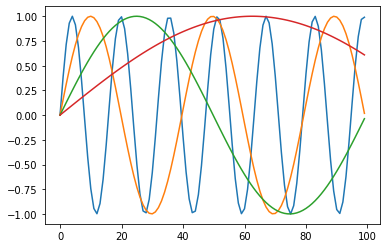

In [0]:
class PositionalEncoding(nn.Module):
    "Encode the position with a sinusoid."
    def __init__(self, d):
        super().__init__()
        self.register_buffer('freq', 1 / (10000 ** (torch.arange(0., d, 2.)/d)))
    
    def forward(self, pos):
        inp = torch.ger(pos, self.freq)
        enc = torch.cat([inp.sin(), inp.cos()], dim=-1)
        return enc

tst_encoding = PositionalEncoding(20)
res = tst_encoding(torch.arange(0,100).float())
_, ax = plt.subplots(1,1)
for i in range(1,5): ax.plot(res[:,i])

class TransformerEmbedding(nn.Module):
    "Embedding + positional encoding + dropout"
    def __init__(self, vocab_sz, emb_sz, inp_p=0.):
        super().__init__()
        self.emb_sz = emb_sz
        self.embed = embedding(vocab_sz, emb_sz)
        self.pos_enc = PositionalEncoding(emb_sz)
        self.drop = nn.Dropout(inp_p)
    
    def forward(self, inp): 
        pos = torch.arange(0, inp.size(1), device=inp.device).float()
        return self.drop(self.embed(inp) * math.sqrt(self.emb_sz) + self.pos_enc(pos))

def feed_forward(d_model, d_ff, ff_p=0., double_drop=True):
    layers = [nn.Linear(d_model, d_ff), nn.ReLU()]
    if double_drop: layers.append(nn.Dropout(ff_p))
    return SequentialEx(*layers, nn.Linear(d_ff, d_model), nn.Dropout(ff_p), MergeLayer(), nn.LayerNorm(d_model))

class MultiHeadAttention(nn.Module):
    def __init__(self, n_heads, d_model, d_head=None, p=0., bias=True, scale=True):
        super().__init__()
        d_head = ifnone(d_head, d_model//n_heads)
        self.n_heads,self.d_head,self.scale = n_heads,d_head,scale
        self.q_wgt,self.k_wgt,self.v_wgt = [nn.Linear(
            d_model, n_heads * d_head, bias=bias) for o in range(3)]
        self.out = nn.Linear(n_heads * d_head, d_model, bias=bias)
        self.drop_att,self.drop_res = nn.Dropout(p),nn.Dropout(p)
        self.ln = nn.LayerNorm(d_model)
        
    def forward(self, q, kv, mask=None):
        return self.ln(q + self.drop_res(self.out(self._apply_attention(q, kv, mask=mask))))
    
    def create_attn_mat(self, x, layer, bs):
        return layer(x).view(bs, x.size(1), self.n_heads, self.d_head
                            ).permute(0, 2, 1, 3)
    
    def _apply_attention(self, q, kv, mask=None):
        bs,seq_len = q.size(0),q.size(1)
        wq,wk,wv = map(lambda o: self.create_attn_mat(*o,bs),
                       zip((q,kv,kv),(self.q_wgt,self.k_wgt,self.v_wgt)))
        attn_score = wq @ wk.transpose(2,3)
        if self.scale: attn_score /= math.sqrt(self.d_head)
        if mask is not None: 
            attn_score = attn_score.float().masked_fill(mask, -float('inf')).type_as(attn_score)
        attn_prob = self.drop_att(F.softmax(attn_score, dim=-1))
        attn_vec = attn_prob @ wv
        return attn_vec.permute(0, 2, 1, 3).contiguous().view(bs, seq_len, -1)

def get_output_mask(inp, pad_idx=1):
    return torch.triu(inp.new_ones(inp.size(1),inp.size(1)), diagonal=1)[None,None].byte()
#     return ((inp == pad_idx)[:,None,:,None].long() + torch.triu(inp.new_ones(inp.size(1),inp.size(1)), diagonal=1)[None,None] != 0)

class EncoderBlock(nn.Module):
    "Encoder block of a Transformer model."
    #Can't use Sequential directly cause more than one input...
    def __init__(self, n_heads, d_model, d_head, d_inner, p=0., bias=True, scale=True, double_drop=True):
        super().__init__()
        self.mha = MultiHeadAttention(n_heads, d_model, d_head, p=p, bias=bias, scale=scale)
        self.ff  = feed_forward(d_model, d_inner, ff_p=p, double_drop=double_drop)
    
    def forward(self, x, mask=None): return self.ff(self.mha(x, x, mask=mask))

class DecoderBlock(nn.Module):
    "Decoder block of a Transformer model."
    #Can't use Sequential directly cause more than one input...
    def __init__(self, n_heads, d_model, d_head, d_inner, p=0., bias=True, scale=True, double_drop=True):
        super().__init__()
        self.mha1 = MultiHeadAttention(n_heads, d_model, d_head, p=p, bias=bias, scale=scale)
        self.mha2 = MultiHeadAttention(n_heads, d_model, d_head, p=p, bias=bias, scale=scale)
        self.ff   = feed_forward(d_model, d_inner, ff_p=p, double_drop=double_drop)
    
    def forward(self, x, enc, mask_out=None): return self.ff(self.mha2(self.mha1(x, x, mask_out), enc))

class Transformer(Module):
    def __init__(self, inp_vsz, out_vsz, n_layers=6, n_heads=8, d_model=256, d_head=32, 
                 d_inner=1024, p=0.1, bias=True, scale=True, double_drop=True, pad_idx=1):
        self.enc_emb = TransformerEmbedding(inp_vsz, d_model, p)
        self.dec_emb = TransformerEmbedding(out_vsz, d_model, 0.)
        args = (n_heads, d_model, d_head, d_inner, p, bias, scale, double_drop)
        self.encoder = nn.ModuleList([EncoderBlock(*args) for _ in range(n_layers)])
        self.decoder = nn.ModuleList([DecoderBlock(*args) for _ in range(n_layers)])
        self.out = nn.Linear(d_model, out_vsz)
        self.out.weight = self.dec_emb.embed.weight
        self.pad_idx = pad_idx
        
    def forward(self, inp, out):
        mask_out = get_output_mask(out, self.pad_idx)
        enc,out = self.enc_emb(inp),self.dec_emb(out)
        enc = compose(self.encoder)(enc)
        out = compose(self.decoder)(out, enc, mask_out)
        return self.out(out)

Train the transformer model using default setting and metrics with using accuracy and BLEU to see how model goes, with loss function of cross entropy analysis and apply early stopping to make sure the model still works well for test data

In [0]:
n_x_vocab,n_y_vocab = len(data.train_ds.x.vocab.itos), len(data.train_ds.y.vocab.itos)

#defalut parameters for Transformer model
model = Transformer(n_x_vocab, n_y_vocab, n_layers=6, n_heads=8, d_model=256, d_head=32, 
                 d_inner=1024)

#here we do cross entropy analysis, you can also do LabelSmoothingCrossEntropy for higher BLEU scores
learn = Learner(data,model,metrics=[accuracy, CorpusBLEU(n_y_vocab)], loss_func = CrossEntropyFlat(), 
                callback_fns=[partial(EarlyStoppingCallback, monitor='accuracy', min_delta=0.01, patience=3)])

Train the model for four cycle. 5e-4 as slice and division fater 5 is the best parameter fine-tuned for language model, detailed in doc https://github.com/fastai/course-nlp/blob/master/8-translation-transformer.ipynb. Here we use four cycles for better performance. Approximately taking ~30 mins

In [0]:
learn.fit_one_cycle(4, 5e-4, div_factor=5)

epoch,train_loss,valid_loss,accuracy,bleu,time
0,2.774173,2.638766,0.542095,0.377131,07:03
1,1.676751,1.565631,0.693251,0.538272,07:08
2,1.394326,1.307349,0.736658,0.592971,07:09
3,1.292863,1.257346,0.744938,0.603571,07:09


Get prediction of the learn model stored in learn.data.train_ds.y

In [0]:
def get_predictions(learn, ds_type=DatasetType.Valid):
    learn.model.eval()
    inputs, targets, outputs = [],[],[]
    with torch.no_grad():
        for xb,yb in progress_bar(learn.dl(ds_type)):
            out = learn.model(*xb)
            for x,y,z in zip(xb[0],xb[1],out):
                inputs.append(learn.data.train_ds.x.reconstruct(x))
                targets.append(learn.data.train_ds.y.reconstruct(y))
                outputs.append(learn.data.train_ds.y.reconstruct(z.argmax(1)))
    return inputs, targets, outputs

Compare input tokens, target code and real output code of 
the model, based on index

In [0]:
inputs, targets, outputs = get_predictions(learn)

Load the two sentencePiece processors to decode the inputs, targets and outputs for predictions

In [0]:
sp1 = spm.SentencePieceProcessor()
sp1.Load("train_py.model")

sp2 = spm.SentencePieceProcessor()
sp2.Load("train_docstring_py.model")

True

Make Text object into list and decode it with corresponding preprocessor. Print the result

In [0]:
def print_result(inputt, targett, outputt):
  i = sp2.decode_pieces(list(inputt.text.split(" ")))
  t = sp1.decode_pieces(list(targett.text.split(" ")))
  o = sp1.decode_pieces(list(outputt.text.split(" ")))

  print("Input docstring: "+i)
  print("Target code snippets: "+t)
  print("Output code snippets: "+o)

We can see here that we actually get a incredibly good prediction based on the input docstring. Target and our models' output are nearly the same, for the followin three show cases (you can do more tests by just changing the index)

In [0]:
print_result(inputs[10],targets[10],outputs[10])

Input docstring: xxbos bins continuous values. bins continuous using the provided bins and assigns labels either computed from each bins center point or from the supplied labels. args: bins: list or array containing the bin boundaries labels: list of labels to assign to each bin if the bins are length n the labels should be length n-1
Target code snippets: xxbos def bin(self, bins, labels=none): """bins continuous values. bins continuous using the provided bins and assigns labels either computed from each bins center point or from the supplied labels. args: bins: list or array containing the bin boundaries labels: list of labels to assign to each bin if the bins are length n the labels should be length n-1 """ return dim(self, bin, bins, labels=labels)
Output code snippets: xxbos def bind_self, bind= bin):none): """ bin continuous values. bin continuous using the provided bins and assigns labels either computed from each bin center point or from the supplied labels. args: bin: list or 

In [0]:
print_result(inputs[1002],targets[1002],outputs[1002])

Input docstring: xxbos search the keys of the given hash using the specified pattern. :param str pattern: pattern used to match keys. :param int count: limit number of results returned. :returns: an iterator yielding matching key / value pairs.
Target code snippets: xxbos def search(self, pattern, count=none): """ search the keys of the given hash using the specified pattern. :param str pattern: pattern used to match keys. :param int count: limit number of results returned. :returns: an iterator yielding matching key / value pairs. """ return self._scan(match=pattern, count=count)
Output code snippets: xxbos def search_self, pattern, count):none): """search the keys of the given hash using the specified pattern. :param str pattern: pattern used to match keys. :param int count: limit number of results returned. :returns: an iterator yielding matching key / value pairs. """ return self.search(self=pattern, count=count,


In [0]:
print_result(inputs[4002],targets[4002],outputs[4002])

Input docstring: xxbos invoke the optional get_requires_for_build_wheel hook returns [] if the hook is not defined.
Target code snippets: xxbos def get_requires_for_build_sdist(config_settings): """invoke the optional get_requires_for_build_wheel hook returns [] if the hook is not defined. """ backend = _build_backend() try: hook = backend.get_requires_for_build_sdist except attributeerror: return [] else: return hook(config_settings)
Output code snippets: xxbos def get_forres_for_build_workel(self):for): """ invoke the optional get_requires_for_build_workheel hook returns [ if the hook is not defined. """ if = getget_backend() for: backend = get.get_forres_for_build_workdist( attributeerror: pass none return: return hookconfig_settings)
